# 1. Signals

The class `Signal` together with the class `Algorithm` are the two main classes in pyphysio.

In this first tutorial we will see how the class `Signal` can be used to facilitate the management and processing of signals.

A signal is an ordered vector of timestamp-value pairs, where the timestamp is the instant at which the measured phenomenon had that value.
In pyphysio a signal is represented by the class **Signal** which extends the numpy.ndarray class.

In this part we will see the different types of signals that can be defined and their properties.

We start importing the packages needed for the tutorial,
And then we import two classess of `pyphysio`: `EvenlySignal` and `UnevenlySignal`, both subclassess of the abstract class `Signal':


In [1]:
# import packages
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
# import the Signal classes
from pyphysio import EvenlySignal, UnevenlySignal
import pyphysio as ph
import pyphysio.filters.Filters as flt # To Filter the data (2.1)
import pyphysio.estimators.Estimators as est # To Estimate the data (2.2)

%matplotlib inline

Please cite:
Bizzego et al. (2019) 'pyphysio: A physiological signal processing library for data science approaches in physiology', SoftwareX


### 1.1 EvenlySignal

When the signal is sampled with a fixed sampling frequency it is sufficient to know the timestamp at which the acquisition started and the sampling frequency (assumed to be constant) to reconstruct the timestamp of each sample. This type of signal is represented by the class **EvenlySignal**.

Therefore to create an instance of **EvenlySignal** these are the input attributes needed:
* ``values`` : (unidimensional numpy array) values of the signal;
* ``sampling_freq`` : (float>0) sampling frequency;
* ``start_time`` : (float) temporal reference of the start of the signal. This is optional, if omitted it will set to 0;
* ``signal_type`` : (string) identifier of the type of the signal. In future releases of pyphysio it will be used to check the appropriateness of the algorithms applied to the signal. Now it is optional and if omitted it will set to ''.

Class functions are provided to facilitate the management and processing of signals. For instance:
* `get_...()` and `set_...()` type functions can be used to check/set signal attributes;
* `plot()` will plot the signal using matplotlib;
* `segment_time(t_start, t_stop)` and `segment_idx(idx_start, idx_stop)` can be used to extract a portion of the signal;
* `resample(fout)` can be used to change the sampling frequency.

#### 1.1.1 Creation of a `EvenlySignal` object

In the following we generate a fake `EvenlySignal` using random generated numbers. Then we will use the methods provided by the class to inspect the signal characteristics:

In [2]:
# create a signal from ECG data

## Open a .csv file with ECG data
#signal_values = np.genfromtxt('ECG_data_100Hz.csv', delimiter=',')
signal_values = np.genfromtxt('Mouse_example_ecg-1000Hz-.txt', delimiter=',')

## set the sampling frequency
fsamp = 1000 # Hz

## set the starting time
tstart = 58 # seconds

## create the Evenly signal and Name it 'ecg'
signal = EvenlySignal(values = signal_values, sampling_freq = fsamp, signal_type  = 'ecg', start_time = tstart)
ecg = signal

# chech signal properties
print('Sampling frequency: {}'.format(signal.get_sampling_freq() ))
print('Start time:         {}'.format(signal.get_start_time() ))
print('End time:           {}'.format(signal.get_end_time() ))
print('Duration:           {}'.format(signal.get_duration() ))
print('Signal type  :      {}'.format(signal.get_signal_type() ))
print('First ten instants: {}'.format(signal.get_times()[0:10] ))

Sampling frequency: 1000
Start time:         58
End time:           1006.703
Duration:           948.703
Signal type  :      ecg
First ten instants: [58.    58.001 58.002 58.003 58.004 58.005 58.006 58.007 58.008 58.009]


#### 1.1.2 Plotting a signal

A shortcut is provided in `pyphysio` to plot a signal, using the `matplotlib` library:

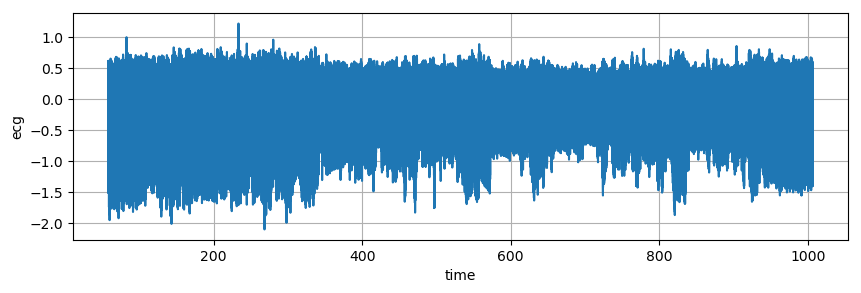

In [3]:
## plot
fig=plt.figure(figsize=(10,3), dpi= 100, facecolor='w', edgecolor='k')
signal.plot()

#### 1.4 Managing the sampling frequency
The sampling frequency of a signal is defined before the acquisition. However it is possible to numerically change it in order to oversample or downsample the signal, according to the signal type and characteristics.

Note in the plot below the effect of downsampling the ECG.

(240, 240.4)

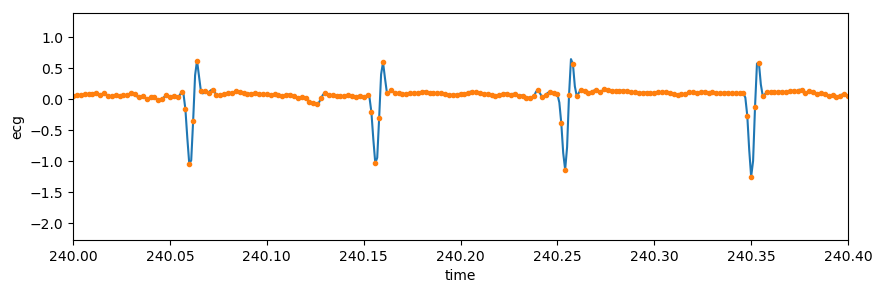

In [4]:
# resampling at 500Hz
ecg_500 = ecg.resample(fout=500)

fig=plt.figure(figsize=(10,3), dpi= 100, facecolor='w', edgecolor='k')

ecg.plot() # plotting the original signal
ecg_500.plot('.') # plotting the samples of the downsampled signal
plt.xlim((240,240.4)) # setting the range of the x axis between 40 and 42 seconds
#plt.ylim((770,830)) # setting the range of the y axis
#plt.autoscale(enable=True, axis='y')

### 1.3 Segmentation of signals

Two general class functions are provided to segment a signal:
1. `segment_time(t_start, t_stop)` is used to extract a portion of the signal between the instants `t_start` and
`t_stop`;
2. `segment_idx(idx_start, idx_stop)` is used to extract a portion of the signal between the indices `idx_start` and `idx_stop`.

The output signal will inherit **`sampling_freq`** and **`signal_nature`** but the **`start_time`** will be set to **`t_start`** or to the instant corresponding to **`idx_start`** accordingly to the method used.

In [5]:
# segmentation of ES
ecg_segment = ecg.segment_time(245, 300)
ecg_segment_idx = ecg.segment_idx(23100, 58960)

245.0
81.1


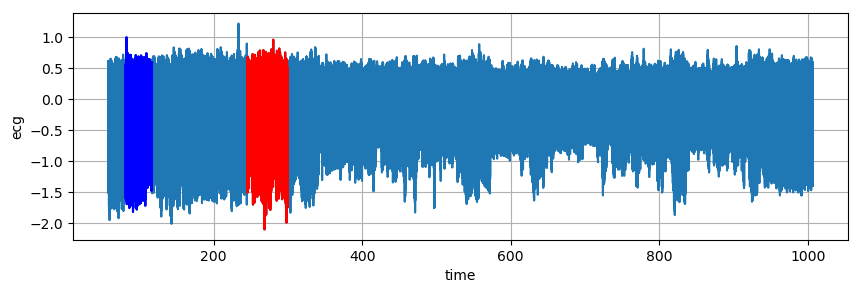

In [6]:
# plot
fig=plt.figure(figsize=(10,3), dpi= 100, facecolor='w', edgecolor='k')

ecg.plot()
ecg_segment.plot('r')
ecg_segment_idx.plot('b')

print(ecg_segment.get_start_time())
print(ecg_segment_idx.get_start_time())

# 2. Algorithms

In this second tutorial we will see how to use the class `Algorithm` to create signal processing pipelines.


A signal processing step is a computational function $F$ that operates on input data (a signal) to produce a result. It is characterized by a set of parameters **p** which regulate its behavior.

![algorithm](img/algorithm.png)

*Figure 1: Abstract representation of a processing step.*

1. In pyphysio each processing step is represented by an instance of a class derived from the generic class `Algorithm`.

2. The type of function or algorithm is given by the class name (e.g. `BeatFromECG` extracts the heartbeats from an ECG signal, `PeakDetection` detects the peaks in the input signal).

3. The parameters of the function/algorithm are the attributes of the created instance.

Therefore, a processing step is defined by creating a new instance of the Class, which is initialized with the given parameters:
```
processing_step = ph.BeatFromECG(parameters)
```
To execute the processing step we need to give as input an instance of the class `Signal`:
```
output = processing_step(input)
```


Algorithms in pyphysio are grouped in four categories (see also the tutorial '3-pipelines'):

* Filters : deterministic algorithms that modify the values of the input signal without changing its nature;
* Estimators : algorithms that aim at extracting information from the input signal which is given in output as a signal with a different nature;
* Indicators : algorithms that operate on the signal to provide a scalar value (or metrics)
* Tools : algorithms that can be useful for the signal processing and return as output one or more numpy arrays or scalars.

### 2.1 Filters

Filters return a signal which has the same **`signal_nature`** of the input signal. 

The name *`Filters`* recalls the aim of this algorithms which is in general to increase the Signal/Noise ratio by filtering out the unwanted components in a signal (e.g high frequency noise).

In [7]:
# help inline
?flt.IIRFilter

In [8]:
# create a Lowpass Filter, at 50Hz:
lowpass_50 = flt.IIRFilter(fp=50, fs=75, ftype='ellip')
# check the filter parameters
print(lowpass_50)

IIRFilter{'fp': 50, 'fs': 75, 'loss': 0.1, 'att': 40, 'ftype': 'ellip'}


In [9]:
# create a Lowpass Filter, at 50Hz:
lowpass_20 = flt.IIRFilter(fp=20, fs=75, ftype='ellip')
# check the filter parameters
print(lowpass_20)

IIRFilter{'fp': 20, 'fs': 75, 'loss': 0.1, 'att': 40, 'ftype': 'ellip'}


In [10]:
#TEST IF THERE ARE NAN in the Array (if results is NaN, there is at least one Nan !)
array_sum = np.sum(ecg)
array_has_nan = np.isnan(array_sum)
print("Does the ecg array contains any NaN ?", array_has_nan)

Does the ecg array contains any NaN ? False


In [11]:
# apply a Filter
#ecg_filtered = lowpass_50(ecg)
ecg_filtered = lowpass_20(ecg)

In [12]:
ecg

<signal: ecg, start_time: 58 freq:1000Hz>
array([-9.610000e-04, -1.795700e-02, -6.095400e-02, ..., -1.194956e+00,
       -1.334974e+00, -7.759650e-01])

In [13]:
ecg_filtered

<signal: ecg, start_time: 58 freq:1000Hz>
array([-0.00401022, -0.00279365, -0.00148283, ..., -0.49057441,
       -0.52190435, -0.550216  ])

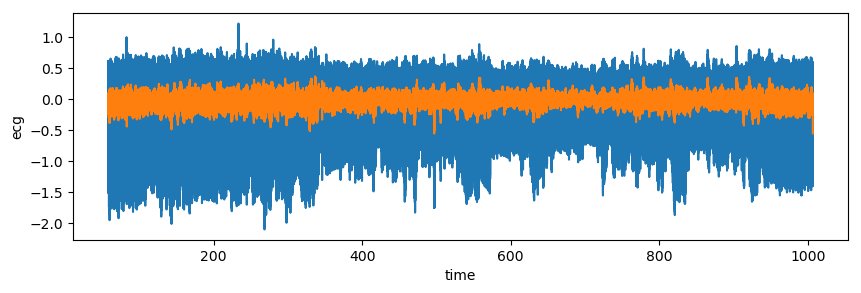

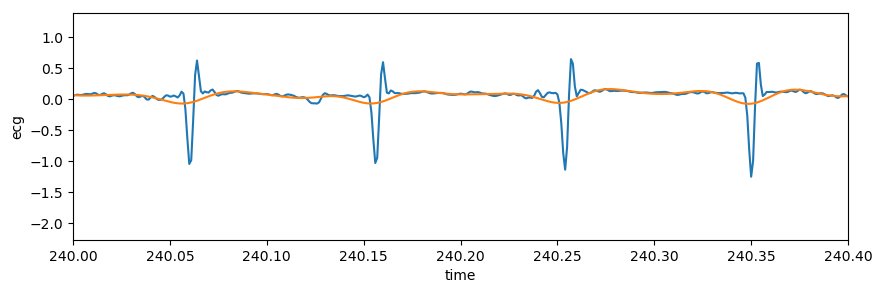

In [14]:
#plot
fig=plt.figure(figsize=(10,3), dpi= 100, facecolor='w', edgecolor='k')
ecg.plot()
ecg_filtered.plot()
plt.show()

fig2=plt.figure(figsize=(10,3), dpi= 100, facecolor='w', edgecolor='k')
ecg.plot()
ecg_filtered.plot()
plt.xlim((240,240.4)) # setting the range of the x axis
plt.show()


In [15]:
# check output type
ecg_filtered.get_signal_type()

'ecg'

### 2.2 Estimators
Estimators are algorithms which aim at extracting the information of interest from the input signal, thus returning a new signal which has a different **`signal_nature`**. 

The name *`Estimators`* recalls the fact that the information extraction depends on the value of the algorithm parameters which might not be known *a-priori*. Thus the result should be considered as an estimate of the real content of information of the input signal.

In [16]:
# create an Estimator:
ibi_ecg = est.BeatFromECG(bpm_max = 400) # IBI, estimates the Inter-beat-Interval from the ecg signal !

# check parameters
print(ibi_ecg)

# apply the Estimator
#ibi = ibi_ecg(ecg_filtered)
print("Computes the IBI ... ")
ibi = ibi_ecg(ecg)
print("IBI estimated !")

# check output type
print("The signal type is:", ibi.get_signal_type())

BeatFromECG{'bpm_max': 400, 'delta': 0, 'k': 0.7}
Computes the IBI ... 
IBI estimated !
The signal type is: IBI


In [ ]:
?ibi_ecg

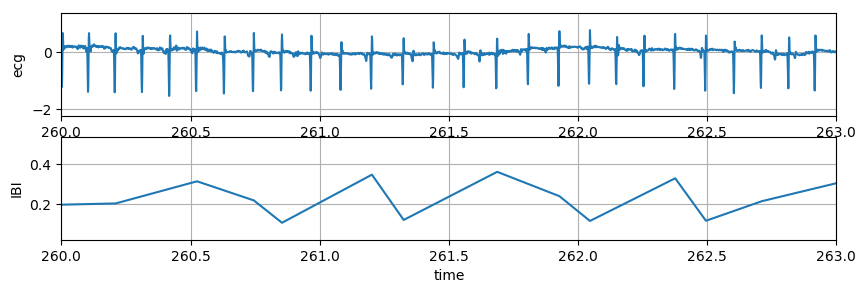

In [17]:
# plot
fig=plt.figure(figsize=(10,3), dpi= 100, facecolor='w', edgecolor='k')

ax1 = plt.subplot(211)
ecg.plot()

plt.subplot(212, sharex=ax1)
plt.xlim([260,263]) 
ibi.plot()

### 3.1 ECG processing pipeline

** Step 0: Import data **

(260, 260.5)

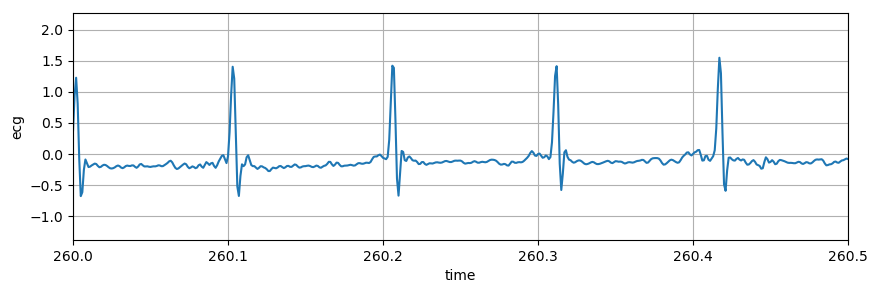

In [18]:
#Plot with more details:
ecg_ = -ecg
fig=plt.figure(figsize=(10,3), dpi= 100, facecolor='w', edgecolor='k')
ecg_.plot()
plt.xlim([260,260.5]) # TO zoom on the x-axis to see the ECG waves

In [19]:
ecg

<signal: ecg, start_time: 58 freq:1000Hz>
array([-9.610000e-04, -1.795700e-02, -6.095400e-02, ..., -1.194956e+00,
       -1.334974e+00, -7.759650e-01])

In [20]:
ecg_

<signal: ecg, start_time: 58 freq:1000Hz>
array([9.610000e-04, 1.795700e-02, 6.095400e-02, ..., 1.194956e+00,
       1.334974e+00, 7.759650e-01])

To better understand how to develop a signal processing pipelines we imagine that the physiological signals were collected during an experiment in which the subject watched two images with different emotional content.

Specifically the experiment is composed of four parts:
* [  0s -  30s] - baseline
* [ 30s -  60s] - image 1
* [ 60s -  90s] - baseline
* [ 90s - 120s] - image 2

We store the information about the experimental sessions in an `EvenlySignal` signal appositely created:

In [21]:
# create labels
len_ecg = len(ecg) #number of rows
stop_time = len_ecg/ecg.get_sampling_freq()
print(f"In 'ecg', there are {len_ecg} rows and the stop-time is {stop_time}s.")
label_fs = 10 # The frequency for the label data: default is 10Hz
label = np.zeros(int(stop_time)*label_fs) #'O' for baseline
label[200*label_fs:300*label_fs] = 1 #'1' between 200 and 300s
label[500*label_fs:600*label_fs] = 2 #'2' between 500 and 600s

label = ph.EvenlySignal(label, sampling_freq = 10, signal_type = 'label')

In 'ecg', there are 948703 rows and the stop-time is 948.703s.


Note that in some other cases a similar signal might be provided by design of the experiment, for instance by using markers or triggers.

** Step 1: Filtering and preprocessing **

In [22]:
# (OPTIONAL) IIR filtering : remove high frequency noise
ecg_filtered = ph.IIRFilter(fp=45, fs = 50, ftype='ellip')(ecg)
ecg_filtered

<signal: ecg, start_time: 58 freq:1000Hz>
array([ 0.00226321,  0.00653668,  0.01038203, ..., -0.57853633,
       -0.67456546, -0.77144693])

In [23]:
# normalization : normalize data
ecg_normalized = ph.Normalize(norm_method='standard')(ecg_filtered)
ecg_normalized

<signal: ecg, start_time: 58 freq:1000Hz>
array([ 0.04833037,  0.08949909,  0.12654353, ..., -5.54683298,
       -6.47193478, -7.40524759])

In [24]:
# resampling : increase the sampling frequency by cubic interpolation
fsamp = 4096
ecg_resampled = ecg_normalized.resample(fout=fsamp, kind='cubic')
ecg_resampled

<signal: ecg, start_time: 58 freq:4096Hz>
array([ 0.04833037,  0.05861616,  0.06877769, ..., -7.5823822 ,
       -7.58826828, -7.49336658])

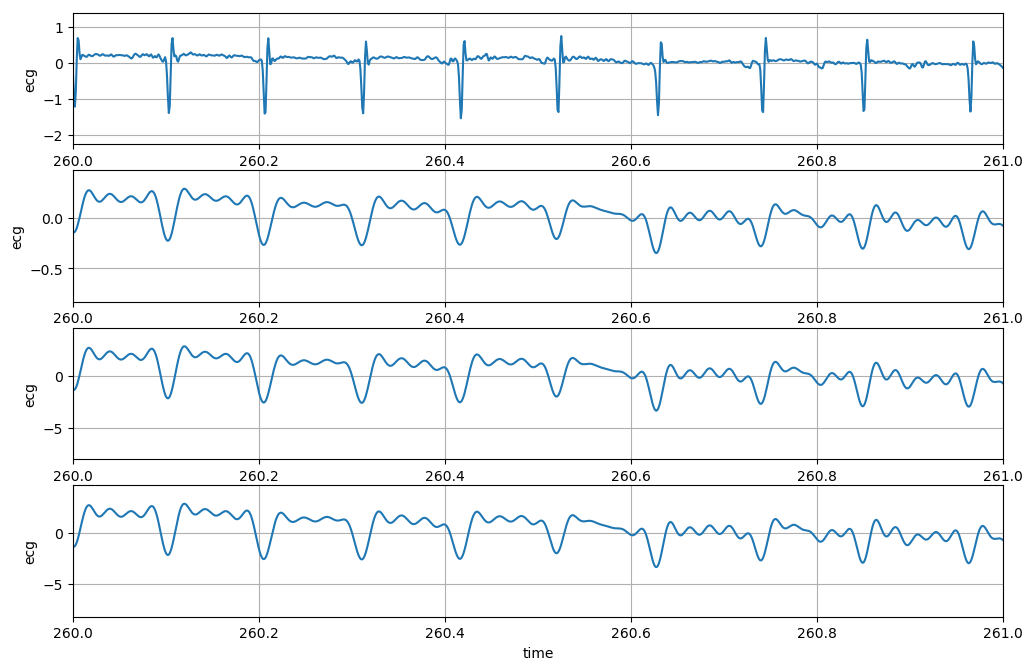

In [25]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

ax1 = plt.subplot(411)
ecg.plot()

plt.subplot(412, sharex = ax1)
ecg_filtered.plot()

plt.subplot(413, sharex = ax1)
ecg_normalized.plot()

plt.subplot(414, sharex = ax1)
ecg_resampled.plot()

plt.xlim([260,261]) # TO zoom on the x-axis to see the ECG waves
plt.show()

In [26]:
#Check the arrays for NaN:
array_sum = np.sum(ecg)
array_has_nan = np.isnan(array_sum)
print("ecg: ", array_sum)

array_sum = np.sum(ecg_filtered)
array_has_nan = np.isnan(array_sum)
print("ecg_filtered: ", array_sum)

array_sum = np.sum(ecg_normalized)
array_has_nan = np.isnan(array_sum)
print("ecg_normalized: ", array_sum)

array_sum = np.sum(ecg_resampled)
array_has_nan = np.isnan(array_sum)
print("ecg_resampled: ", array_sum)

ecg:  -2612.9311190000003
ecg_filtered:  -2612.416646075643
ecg_normalized:  -3.410605131648481e-12
ecg_resampled:  -15.619524718125263


** Step 2: Information Extraction **

The information we want to extract from the ECG signal is the position of the heartbeats and the Inter Beat Interval signal.

In [27]:
ibi = ph.BeatFromECG()(ecg)
ibi_filtered = ph.BeatFromECG()(ecg_filtered)
ibi_normalized = ph.BeatFromECG()(ecg_normalized)
ibi_resampled = ph.BeatFromECG()(ecg_resampled)

In [28]:
print(ibi.get_duration())
print(ibi_filtered.get_duration())
print(ibi_normalized.get_duration())
print(ibi_resampled.get_duration())

948.703
948.703
948.703
948.703125


In [29]:
#For ECG inverted
ibi_ = ph.BeatFromECG()(ecg_)

2378.0
2378.0
2378.0
2378.0


In [30]:
?ibi

Type:        UnevenlySignal
String form: [0.112 0.112 0.956 ... 0.15  0.61  0.664]
Length:      4179
File:        c:\users\damie\anaconda3\lib\site-packages\pyphysio\signal.py
Docstring:  
Unevenly spaced signal

Attributes:
-----------

data : numpy.array
    Values of the signal
sampling_freq : float, >0
    Sampling frequency
start_time: float,
    Instant of signal start
signal_type : str, default = ''
    Type of signal (e.g. 'ECG', 'EDA')


x_values : numpy.array of int
    Instants, or indices when the values are measured.
x_type : str
    Type of x values given.
    Can be 'indices' or 'instants'

duration: float,
    Duration of the original EvenlySignal, if any. Duration is needed to have information about the duration of the
    last sample, if None the last sample will last 1. / fsamp.


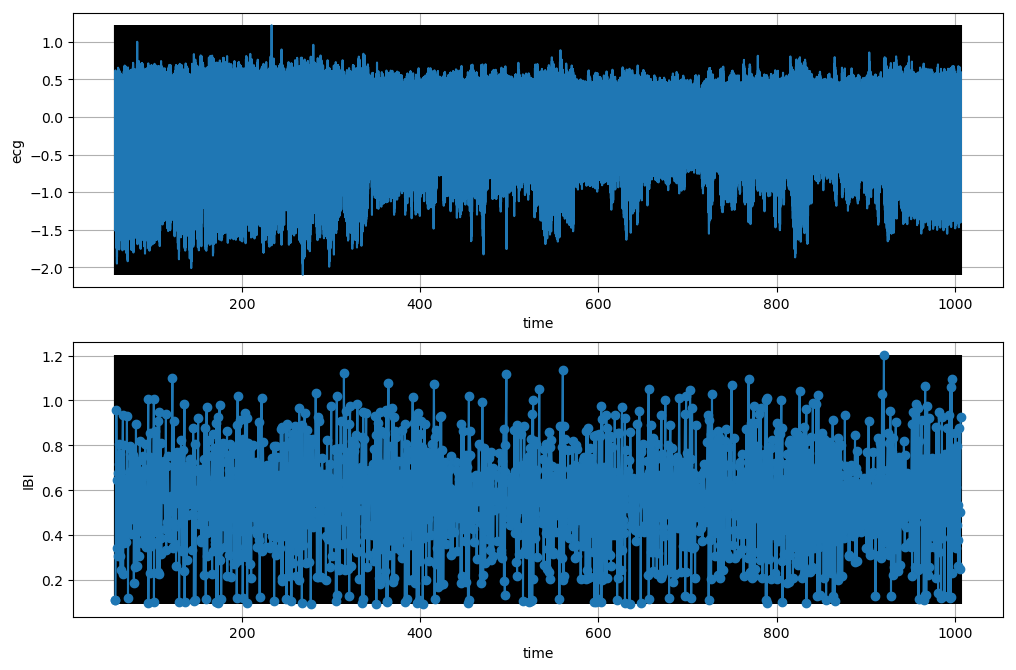

In [45]:
# check results so far (ENTIRE DATASET)
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax1 = plt.subplot(211)
ecg.plot()
plt.vlines(ibi.get_times(), np.min(ecg), np.max(ecg))

plt.subplot(212, sharex = ax1)
ibi.plot('o-')
plt.vlines(ibi.get_times(), np.min(ibi), np.max(ibi))
plt.show()

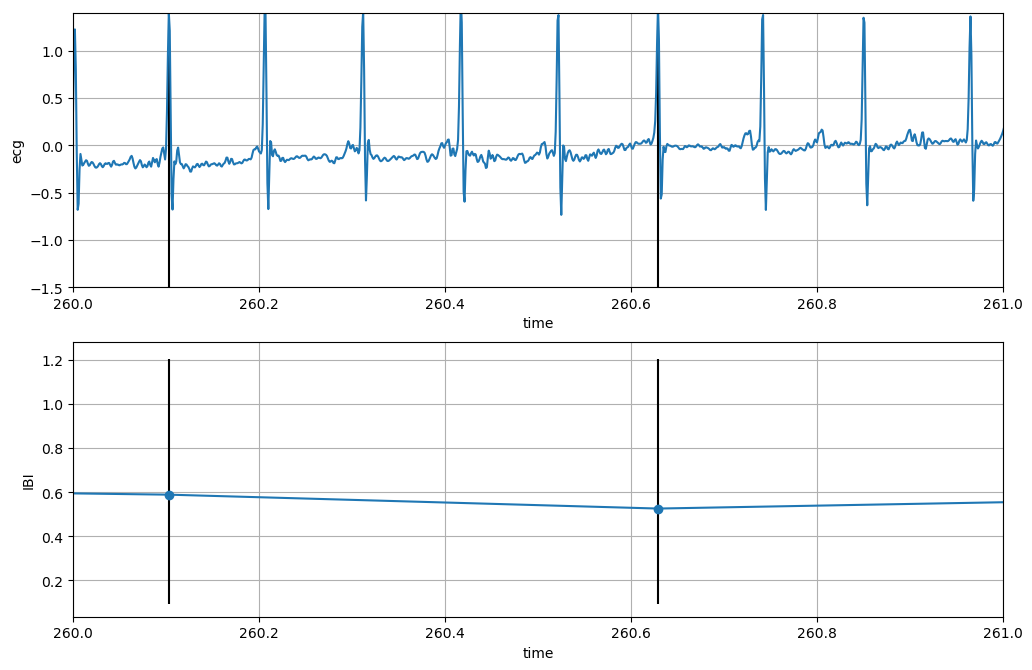

In [55]:
# check results so far (MORE IN DETAILS)
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax1 = plt.subplot(211)
ecg_.plot()
plt.vlines(ibi_.get_times(), np.min(ecg), np.max(ecg))
ax1.set_ylim([-1.5, 1.4])

plt.subplot(212, sharex = ax1)
ibi_.plot('o-')
plt.vlines(ibi_.get_times(), np.min(ibi), np.max(ibi))
plt.xlim([260,261])
plt.show()

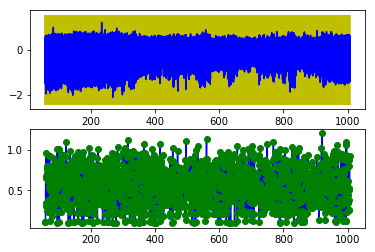

KeyboardInterrupt: 

In [64]:
# edit IBI
ibi_ok = ph.Annotate(ecg, ibi)()

### 2.3 Indicators

Indicators are algorithm which extract a metrics (scalar value) from the input signal, for instance a statistic (average).

Three types of indicators are provided in **`pyphysio`**:
* Time domain indicators: comprising simple statistical indicators and other metrics that can be computed on the signal values;
* Frequency domain indicators: metrics that are computed on the Power Spectrum Density (PSD) of the signal;
* Non-linear indicators: complex indicators that are computed on the signal values (e.g. Entropy).

In [65]:
import pyphysio.indicators.ComputeAllIndicators_hd as CAI

#Save the indicators in dictionnaries:
print(" - -- - Time Domain Indicators - -- - ")
time_indicators = CAI.TimeDomain()
time_dict = time_indicators(ibi)
print(time_dict)

print(" - -- - Frequency Domain Indicators - -- - ")
frequency_indicators = CAI.FrequencyDomain()
freq_dict = frequency_indicators(ibi)
print(freq_dict)

print(" - -- - Non-Linear Indicators - -- - ")
nonlinear_indicators = CAI.NonLinearDomain()
nonlinear_dict = nonlinear_indicators(ibi)
print(nonlinear_dict)


 - -- - Time Domain Indicators - -- - 
{'rmssd': 0.3889438409312518, 'mean': 0.5570164415736935, 'min': 0.092, 'max': 1.204, 'range': 1.1119999999999999, 'median': 0.563, 'stdev': 0.22427675831786784, 'sum': 948.599, 'auc': 0.9485990000000001, 'auc_detrended': 0.06296103986284428, 'sdsd': 0.38894354544010284, 'triang': nan, 'tinn': nan}
 - -- - Frequency Domain Indicators - -- - 


NameError: name 'freq_min' is not defined

In [55]:
"""# create an Indicator
import pyphysio.indicators.TimeDomain as td_ind
import pyphysio.indicators.FrequencyDomain as fd_ind
import pyphysio.indicators.NonLinearDomain as nld_ind

# Creates the Time Domain Indicators
rmssd = td_ind.RMSSD()
mean = td_ind.Mean()
min = td_ind.Min()
max = td_ind.Max()
range = td_ind.Range()
median = td_ind.Median()
stdev = td_ind.StDev()
sum = td_ind.Sum()
auc = td_ind.AUC()
auc_detrended = td_ind.DetrendedAUC()
sdsd = td_ind.SDSD()
triang = td_ind.Triang()
tinn = td_ind.TINN()

# Frequency Domain Indicators
VLF = fd_ind.PowerInBand(interp_freq=4, freq_max=0.04, freq_min=0, method = 'ar')
LF = fd_ind.PowerInBand(interp_freq=4, freq_max=0.15, freq_min=0.04, method = 'ar')
HF = fd_ind.PowerInBand(interp_freq=4, freq_max=0.4, freq_min=0.15, method = 'ar')

# Non-Linear Domain Indicators
sd1 = nld_ind.PoincareSD1()
sd2 = nld_ind.PoincareSD2()
sd1sd2 = nld_ind.PoincareSD1SD2() # SD1/SD2
poinell = nld_ind.PoinEll()
pnnx = nld_ind.PNNx(threshold=0.1) # Relative frequency of pairs of consecutive samples s1, s2 
nnx = nld_ind.NNx(threshold=0.1) # Counts the pairs of consecutive samples s1, s2
entropy_approx = nld_ind.ApproxEntropy()
entropy_sample = nld_ind.SampleEntropy()
dfa_short = nld_ind.DFAShortTerm()
dfa_long = nld_ind.DFALongTerm()

## apply Indicators

# Time Domain:
rmssd_ = rmssd(ibi)
mean_ = mean(ibi)
min_ = min(ibi)
max_ = max(ibi)
range_ = range(ibi)
median_ = median(ibi)
stdev_ = stdev(ibi)
sum_ = sum(ibi)
auc_ = auc(ibi)
auc_detrended_ = auc_detrended(ibi)
sdsd_ = sdsd(ibi)
triang_ = triang(ibi)
tinn_ = tinn(ibi)

# Freq domain
VLF_ = VLF(ibi.resample(4)) #resampling is needed to compute the Power Spectrum Density
LF_ = LF(ibi.resample(4)) #resampling is needed to compute the Power Spectrum Density
HF_ = HF(ibi.resample(4)) #resampling is needed to compute the Power Spectrum Density

# NonLinear:
sd1_ = sd1(ibi)
sd2_ = sd2(ibi)
sd1sd2_ = sd1sd2(ibi)
poinell_ = poinell(ibi)
pnnx_ = pnnx(ibi)
nnx_ = nnx(ibi)
entropy_approx_ = entropy_approx(ibi)
entropy_sample_ = entropy_sample(ibi)
dfa_short_ = dfa_short(ibi)
dfa_long_ = dfa_long(ibi)

print(" - -- - Time Domain Indicators - -- - ")
print("RMSSD =", rmssd_)
print("MEAN =", mean_)
print("MIN =", min_)
print("MAX =", max_)
print("RANGE =", range_)
print("MEDIAN =", median_)
print("StDev =", stdev_)
print("SUM =", sum_)
print("AUC =", auc_)
print("AUD detrended =", auc_detrended_)
print("SDSD =", sdsd_)
print("Triang =", triang_)
print("TINN =", tinn_)
print(" - -- - Frequency Domain Indicators - -- - ")
print("VLF =", VLF_)
print("LF =", LF_)
print("HF =", HF_)
print(" - -- - NonLinear Indicators - -- - ")
print("SD1 =", sd1_)
print("SD2 =", sd2_)
print("poinell_ =", poinell_)
print("pnnx_ =", pnnx_)
print("nnx_ =", nnx_)
print("entropy_approx_ =", entropy_approx_)
print("entropy_sample_ =", entropy_sample_)
print("dfa_short_ =", dfa_short_)
print("dfa_long_ =", dfa_long_)"""

** Step 3: Physiological Indicators **

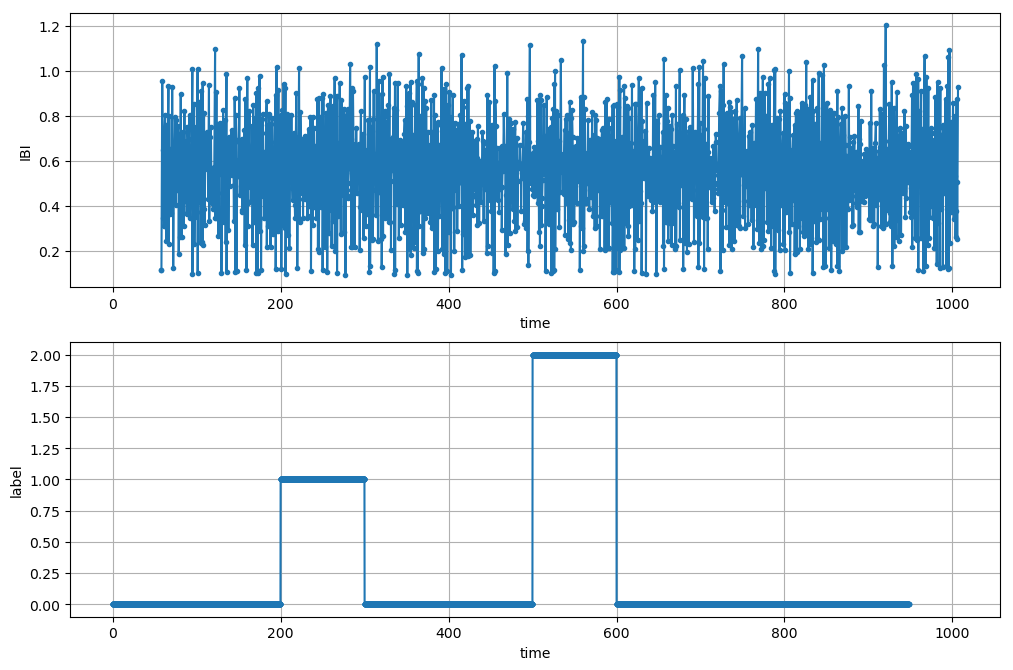

In [66]:
# check label
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax1 = plt.subplot(211)
ibi.plot('.-')

plt.subplot(212, sharex = ax1)
label.plot('.-')
plt.show()

In [68]:
# define a list of indicators we want to compute
hrv_indicators = [ph.Mean(name='RRmean'), ph.StDev(name='RRstd'), ph.RMSSD(name='rmsSD')]
print(hrv_indicators)

[RRmean, RRstd, rmsSD]


In [14]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 5, width = 10, labels = label)

indicators, col_names = ph.fmap(fixed_length, hrv_indicators, ibi)

In [15]:
# extract column with the labels for each window
label_w = indicators[:, np.where(col_names == 'label')[0]]

# extract column with the RRmean values computed from each window
rrmean_w = indicators[:, np.where(col_names == 'RRmean')[0]]

rrmean_image1 = rrmean_w[np.where(label_w==1)[0]].ravel()
rrmean_image2 = rrmean_w[np.where(label_w==2)[0]].ravel()

{'whiskers': [<matplotlib.lines.Line2D at 0x174b0d5c6a0>,
 'caps': [<matplotlib.lines.Line2D at 0x174b0d5cf60>,
 'boxes': [<matplotlib.lines.Line2D at 0x174b0d5c0f0>,
 'medians': [<matplotlib.lines.Line2D at 0x174b0d63828>,
 'fliers': [<matplotlib.lines.Line2D at 0x174b0d63c88>,
 'means': []}

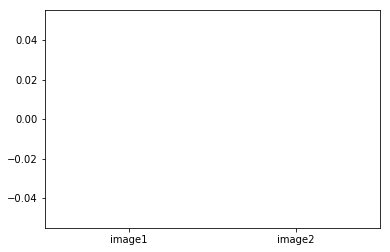

In [16]:
## create a box and whisker plot to compare the distibution of the RRmean indicator
plt.boxplot([rrmean_image1, rrmean_image2],
            labels=['image1', 'image2'])

`pyphysio` provides by default some presets of standard indicators for Heart Rate Variability and Electrodermal activity analysis.

Each indicator has its own pre-defined parameters:

In [17]:
HRV_FD = ph.preset_hrv_fd() #frequency domain HRV indicators
print(HRV_FD)

print(HRV_FD[0].get())

[IBI_VLF_Pow, IBI_LF_Pow, IBI_HF_Pow, IBI_Total_Pow]
{'freq_min': 1e-05, 'freq_max': 0.04, 'method': 'ar', 'interp_freq': 4, 'name': 'IBI_VLF_Pow'}


If a customization of the indicators is not required, it is easier to directly use them instead of manually define each indicator:

In [18]:
FD_HRV_ind, col_names = ph.fmap(fixed_length, ph.preset_hrv_fd(), ibi.resample(4))

C:\Users\damie\Anaconda3\lib\site-packages\pyphysio\tools\Tools.py:401: RuntimeWarning: invalid value encountered in double_scalars
  temp = -save / P
C:\Users\damie\Anaconda3\lib\site-packages\pyphysio\tools\Tools.py:373: RuntimeWarning: invalid value encountered in true_divide
  acor = acov/acov[0]
C:\Users\damie\Anaconda3\lib\site-packages\scipy\signal\filter_design.py:470: RuntimeWarning: invalid value encountered in true_divide
  npp_polyval(zm1, a, tensor=False))


If you need to export the results, for instance in a .csv datafile, you can use `pandas`:

In [19]:
import pandas as pd

# create a pandas dataframe
FD_HRV_df = pd.DataFrame(FD_HRV_ind, columns=col_names)

FD_HRV_df

,begin,end,label,IBI_VLF_Pow,IBI_LF_Pow,IBI_HF_Pow,IBI_Total_Pow
0,0.485107,10.485107,0.0,36.454146,130.631729,308.593639,1184.312870
1,5.485107,15.485107,0.0,NaN,NaN,NaN,NaN
2,10.485107,20.485107,0.0,19.327490,55.579105,129.586602,1023.052286
3,15.485107,25.485107,0.0,46.236854,148.241426,306.097828,1189.478810
4,20.485107,30.485107,0.0,50.086596,139.624056,266.995158,1178.383068
5,25.485107,35.485107,0.0,21.443224,63.536199,218.350891,1194.323093
6,30.485107,40.485107,0.0,11.312206,36.184005,282.407290,1305.495994
7,35.485107,45.485107,0.0,66.733890,210.500678,423.983318,1379.581260
8,40.485107,50.485107,0.0,23.121507,80.292360,542.171039,1363.569636
9,45.485107,55.485107,0.0,35.613286,93.907507,470.198576,1333.734146


In [20]:
# and save it to a .csv file:

FD_HRV_df.to_csv('HRV_data_output.csv')

In [21]:
# BE CAREFUL when executing the above command (uncomment first) 
# as it will save a new file in your current working directory.
# To check your current working directory:
import os
print(os.getcwd())

C:\Users\damie\Documents\GitHub-python\pyphysio-master\tutorials


### 2.4 Tools

This is a collection of useful algorithms that can be used for signal processing. 

These algorithms might return scalar values or numpy arrays.

In [43]:
# create a Tool
import pyphysio.tools.Tools as tll

compute_psd = tll.PSD(method='ar', interp_freq = 4)

In [44]:
# check parameters
compute_psd

PSD{'method': 'ar', 'nfft': 2048, 'window': 'hamming', 'min_order': 10, 'max_order': 30, 'normalize': False, 'remove_mean': True, 'interp_freq': 4}

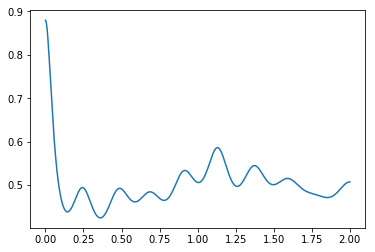

In [45]:
# apply a Tool
frequencies, power = compute_psd(ibi.resample(4))

plt.plot(frequencies, power)
plt.show()